# Setup

## Imports

In [1]:
# Basic Libraries
import warnings
import pandas as pd
import numpy as np

# EDA
import sweetviz as sv
from skimpy import skim, clean_columns
from klib import convert_datatypes
from klib import describe
from dython import nominal

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

## Configurations and Functions

In [2]:
# Defining plot standard parameters
plt.rcParams.update({
    "axes.labelcolor": "#595959",
    "axes.facecolor": (0, 0, 0, 0),
    "axes.grid": False,
    "axes.labelpad": 6,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (9.25, 2.5),
    "figure.facecolor": (0, 0, 0, 0),
    "figure.dpi": 100,
    "legend.edgecolor": "#D9D9D9",
    "legend.borderaxespad": 0,
    "legend.framealpha": None,
    "legend.fontsize": 8,
    "legend.loc": "upper right",
    "legend.title_fontsize": 9,
    "text.color": "#595959",
    "xtick.color": "#D9D9D9",
    "xtick.labelcolor": "#595959",
    "ytick.color": "#D9D9D9",
    "ytick.labelcolor": "#595959"
})

In [3]:
def plot_bar_over_time(df_for_plot, col, ylabel, dpi=200, format_as_currency=False):
    # Creating Figure
    fig, ax = plt.subplots(dpi=dpi)
    # Plotting Axes
    ax.bar(x=df_for_plot.index, height=col, data=df_for_plot, width=20)  # Adjust the width parameter as needed
    # Setting Ticks
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    # ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Adjust the interval as needed
    fig.autofmt_xdate(rotation=0, ha="center")  # Auto format date labels
    # Labeling
    ax.set_ylabel(ylabel=ylabel, loc="top")
    for container in ax.containers:
        if format_as_currency:
            labels = [f"{bar.get_height()/1000:.0f}k" if bar.get_height() >= 1000 else f"{bar.get_height():.1f}" for bar in container]
        else:
            labels = [f"{bar.get_height():.0f}" for bar in container]
        ax.bar_label(container, labels=labels, label_type="edge", color="#1f77b4", size=6)
    # Setting Labels Aesthetics
    ax.spines["bottom"].set_color("#D9D9D9")
    ax.spines["left"].set_color("#D9D9D9")

    return ax

In [4]:
def plot_distribution(data, xlabel, dpi=200):
    """
    """
    with sns.plotting_context(rc={
        "axes.facecolor":(0,0,0,0), 
        "figure.facecolor":(0,0,0,0), 
        "figure.dpi": dpi
    }):
        # Getting Stats
        mean = data.mean().item()
        std = data.std().item()
        median = data.median().item()
        skew = data.skew().item()
        kurtosis = data.kurtosis().item()
        # Setting Parameters
        rug_kws = ({"color": "#ff3333", "alpha": 0.15, "lw": 3, "height": 0.1})
        kde_kws = ({"alpha": 0.75, "linewidth": 1.5, "bw_adjust": 1.5})  # Increased bw_adjust to 1.5
        # Creating FacetGrid
        grid = sns.displot(
            data,
            kind="kde",
            rug=True,
            legend=False,
            height=2.5,
            aspect=3.7,
            rug_kws=rug_kws,
            **kde_kws,
        );
        # Filling quantile range
        x, y = grid.ax.lines[0].get_xydata().T
        grid.ax.fill_between(
            x,
            y,
            where=(
                (x >= np.quantile(data, 0.025))
                & (x <= np.quantile(data, 0.975))
            ),
            label=f"{0.025*100:.1f}% - {0.975*100:.1f}%",
            color="#80d4ff",
            alpha=0.2
        )
        # Creating Lines
        grid.ax.vlines(
            x=mean,
            ymin=0,
            ymax=np.interp(mean, x, y),
            ls="dotted",
            color="orange",
            lw=2,
            label="média",
        )
        grid.ax.vlines(
            x=median,
            ymin=0,
            ymax=np.interp(median, x, y),
            ls=":",
            color=".3",
            label="mediana",
        )
        grid.ax.vlines(
            x=[mean - std, mean + std],
            ymin=0,
            ymax=[np.interp(mean - std, x, y), np.interp(mean + std, x, y)],
            ls=":",
            color=".5",
            label="\u03BC \u00B1 \u03C3",
        )

        # Positioning plot on customized limits
        grid.ax.set_ylim(0)
        grid.ax.set_xlim(
            grid.ax.get_xlim()[0] - grid.ax.get_xlim()[1] * 0.05, grid.ax.get_xlim()[1] * 1.03,
        )
        # Annotations and legend
        grid.ax.text(0.01, 0.9, f"Média: {mean:.2f}", transform=grid.ax.transAxes,)
        grid.ax.text(0.01, 0.8, f"Mediana: {median:.2f}", transform=grid.ax.transAxes,)
        grid.ax.text(0.01, 0.7, f"Desv Pad: {std:.2f}", transform=grid.ax.transAxes,)
        grid.ax.text(0.01, 0.6, f"Skew: {skew:.2f}", transform=grid.ax.transAxes,)
        grid.ax.text(0.01, 0.5, f"Kurtosis: {kurtosis:.2f}", transform=grid.ax.transAxes,)
        grid.ax.text(0.01, 0.4, f"Contagem: {len(data)}",  transform=grid.ax.transAxes,)
        # Setting Labels Aesthetics
        grid.ax.legend(loc="upper right", fontsize=9)
        grid.despine(left=True)
        grid.ax.spines["bottom"].set_color("#D9D9D9")
        grid.ax.set_ylabel(None)
        grid.ax.get_yaxis().set_visible(False)
        grid.ax.set_xlabel(xlabel)

        return grid

# Ingesting Data

In [5]:
# List of report files
reports = [
    "Report 1.csv",
    "Report 2.csv",
    "Report 3.csv",
    "Report 4.csv",
    "Report 5.csv",
]

# Initialize an empty list to store dataframes
df_list = []

for report in reports:
    # Ingesting Data
    df_temp = (
        clean_columns(
            df=convert_datatypes(
                data=(
                    pd.read_csv(
                        filepath_or_buffer=f"../data/raw/{report}",
                        usecols=(
                            "Order",
                            "Creation Date",
                            "UF",
                            "City",
                            "UtmSource",
                            "Coupon",
                            "Total Value",
                            "Client Hash",
                        ),
                        delimiter=";",
                        parse_dates=["Creation Date"],
                    )
                ),
                cat_threshold=0.5
            )
            .dropna(subset="Client Hash"),
            case="snake"
        )
    )
    # Append the dataframe to the list
    df_list.append(df_temp)

# Concatenate all dataframes
df = pd.concat(df_list, ignore_index=True)

# Saving concatenated data to processed folder
df.to_csv(path_or_buf="../data/processed/report.csv", index=False)

# Overall Reports

In [6]:
# Sweetviz
with warnings.catch_warnings():  # Ignoring pandas future warnings of SweetViz
    warnings.filterwarnings("ignore")
    sv_eda_report = sv.analyze(source=df)
sv_eda_report.show_html(filepath="../reports/report.html", layout="vertical")

                                             |          | [  0%]   00:00 -> (? left)

Report ../reports/report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [7]:
# Skimpy
skim(df.drop(columns="creation_date"))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 129256 │ │ string      │ 5     │                                                          │
│ │ Number of columns │ 7      │ │ bool        │ 1     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA   ┃ NA %   ┃ mean     ┃ sd      ┃ p0   ┃ p25     ┃ p50     ┃ p75   ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ total_value      │    0 │      0 │    326.4 │   300.1 │    0 │   162.1 │   249.7 │   407 │  6676 │    ▇    │  │
│ └──────────────────┴──────┴────────┴──────────┴─────────┴──────┴─────────┴─────────┴───────┴───────┴─────────┘  │
│                                                      bool                                                       │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                       ┃ true              ┃ true rate                    ┃ hist                ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ coupon                            │             65924 │                         0.51 │       ▇    ▇        │  │
│ └───────────────────────────────────┴───────────────────┴──────────────────────────────┴─────────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name             ┃ NA           ┃ NA %        ┃ words per row              ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ order                   │            0 │           0 │                          1 │                 129256 │  │
│ │ uf                      │            0 │           0 │                          1 │                 129257 │  │
│ │ city                    │            0 │           0 │                        1.7 │                 224896 │  │
│ │ utm_source              │        83528 │       64.62 │                       0.35 │                  45744 │  │
│ │ client_hash             │            0 │           0 │                          1 │                 129256 │  │
│ └─────────────────────────┴──────────────┴─────────────┴────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

# Exploration

In [8]:
min_date = df["creation_date"].min()
max_date = df["creation_date"].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2023-01-02 00:32:47+00:00
Maximum date: 2024-11-11 10:29:20+00:00


## Order Centric

In [9]:
df_agg_by_order = df.groupby("order").agg({
    "creation_date": "first",
    "uf": "first",
    "city": "first",
    "utm_source": "first",
    "coupon": "first",
    "total_value": "first",
    "client_hash": "first",
    "order": "size"
}).rename(columns={"order": "distinct_itens"}).reset_index()

display(df_agg_by_order)

,order,creation_date,uf,city,utm_source,coupon,total_value,client_hash,distinct_itens
0,1300281217232-01,2023-01-02 00:32:47+00:00,SC,Bom Retiro,None,False,139.449997,bfd96e74704094f6b5d8a92b809831f4a529eef8d89285...,1
1,1300281217234-01,2023-01-02 00:35:59+00:00,RJ,Mesquita,None,False,186.949997,538f64627ed9baeb6c5284b87969fda6181f0d0839f939...,1
2,1300281217238-01,2023-01-02 01:12:20+00:00,RS,Restinga Seca,None,True,125.000000,891f2ad51f7cb31fdadbe3b8791e1594d0591b025f8b57...,1
3,1300301217240-01,2023-01-02 02:52:22+00:00,MG,Leopoldina,None,False,48.180000,0a087fb89eee1a01475e1bee723ce164ede802f3c76dd4...,1
4,1300301217242-01,2023-01-02 03:18:09+00:00,MG,Betim,None,True,1080.000000,873877e3e2bb6db7a472b5d7dfa570bacc24d507dabfe4...,8
...,...,...,...,...,...,...,...,...,...
61638,1475731372100-01,2024-11-11 09:56:04+00:00,PE,Condado,LeanApp,False,192.470001,78c04d377cf3683f88747cd82814ae80808f867b2281cc...,1
61639,1475731372102-01,2024-11-11 10:03:50+00:00,RJ,Rio de Janeiro,google,False,113.849998,9cea2d17f05318cea42a4bc6c69951e2a9a9db7c21f1f3...,1
61640,1475731372104-01,2024-11-11 10:21:45+00:00,RS,Porto Alegre,google,True,187.360001,6fa0d6cb6abe647c38baf253ed6638c8b85cb2cfaf0b65...,1
61641,1475731372106-01,2024-11-11 10:28:59+00:00,SP,Presidente Prudente,None,True,126.000000,5c081390aae7c2c2b6982a4cbdc972cb283b0d1252cd82...,1


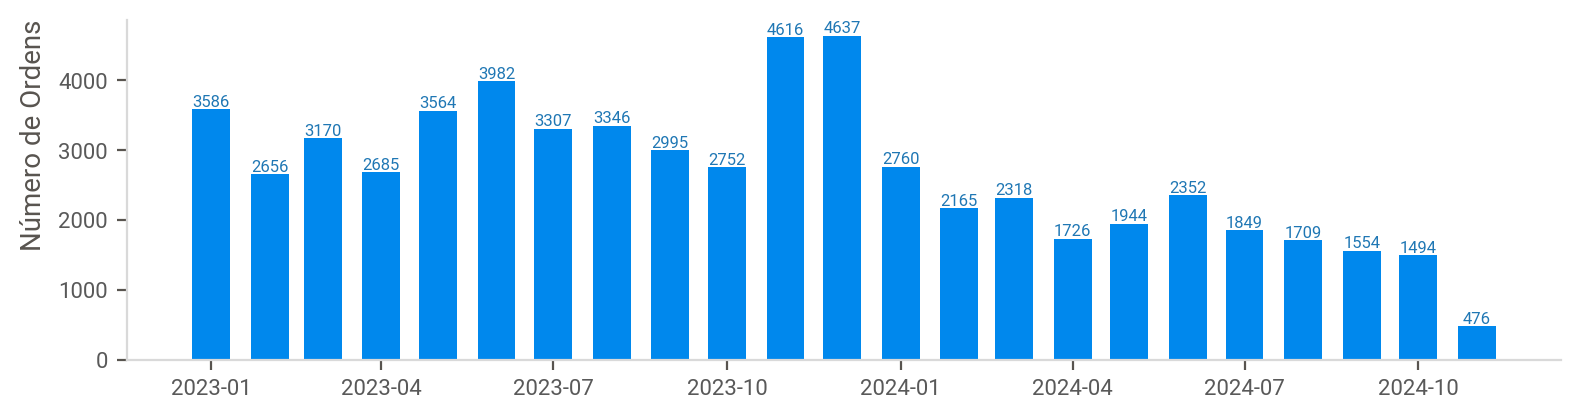

In [10]:
df_for_plot = (
    df_agg_by_order[["creation_date", "order"]]
    .set_index("creation_date")
    .sort_index()
    .resample("MS")
    .count()
)

plot_bar_over_time(
    df_for_plot=df_for_plot, 
    col="order", 
    ylabel="Número de Ordens",
    format_as_currency=False,
);


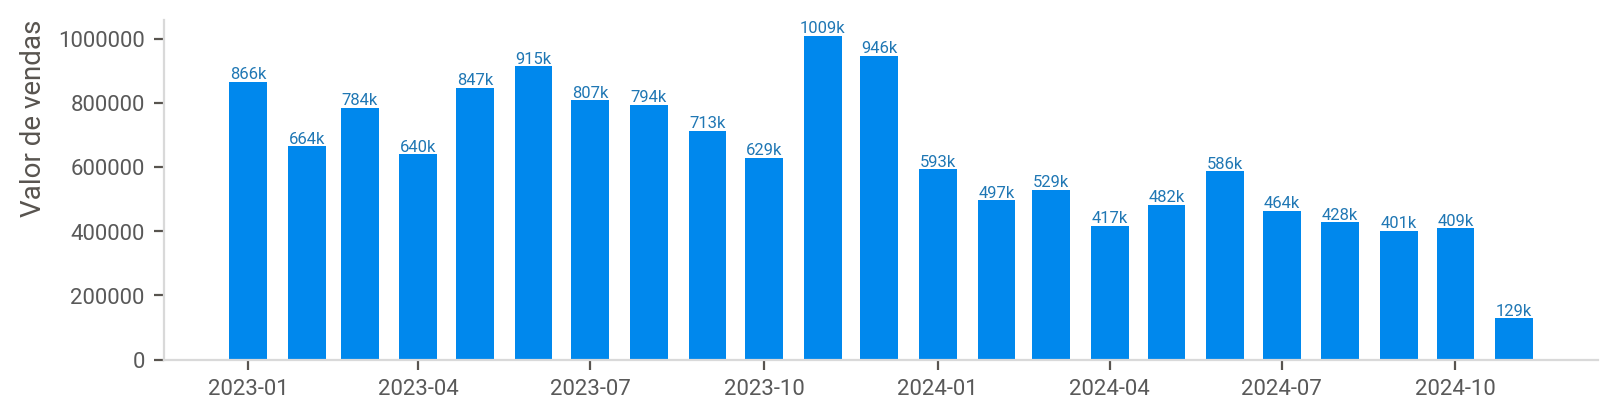

In [11]:
df_for_plot = (
    df_agg_by_order[["creation_date", "total_value"]]
    .set_index("creation_date")
    .sort_index()
    .resample("MS")
    .sum()
)

plot_bar_over_time(
    df_for_plot=df_for_plot, 
    col="total_value", 
    ylabel="Valor de vendas",
    format_as_currency=True,
);

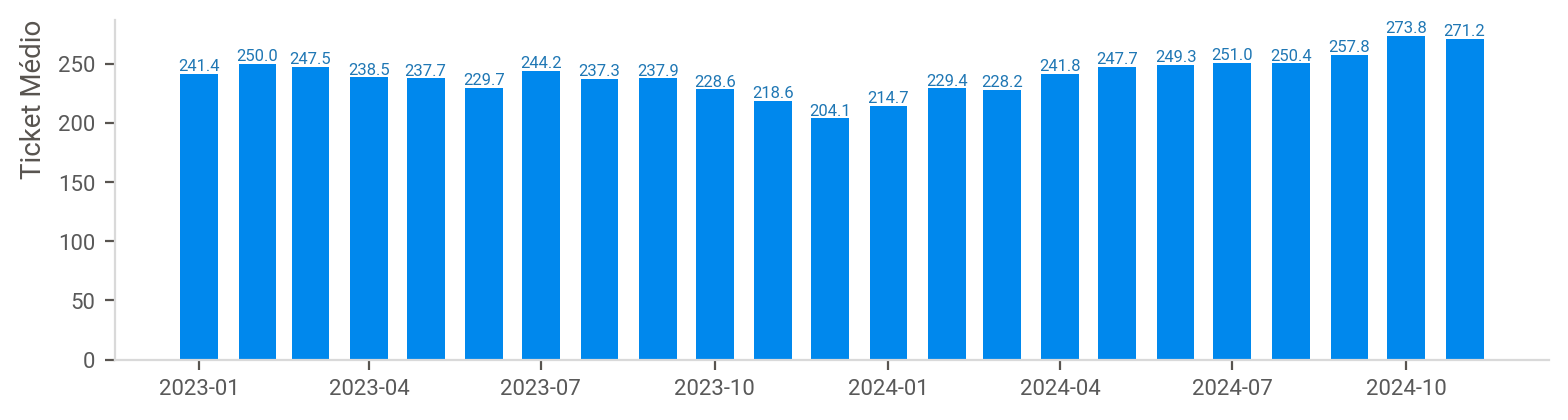

In [12]:
df_for_plot = (
    df_agg_by_order[["creation_date", "total_value"]]
    .set_index("creation_date")
    .sort_index()
    .resample("MS")
    .mean()
)

plot_bar_over_time(
    df_for_plot=df_for_plot, 
    col="total_value", 
    ylabel="Ticket Médio",
    format_as_currency=True,
);

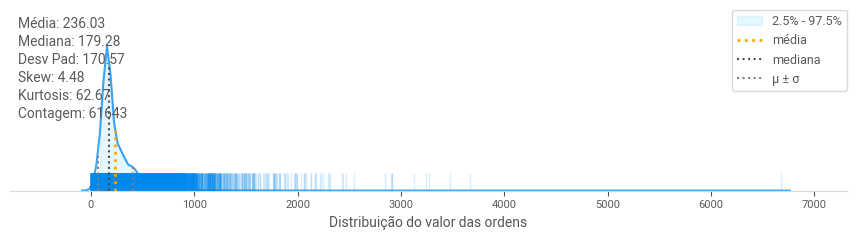

In [13]:
df_for_plot = df_agg_by_order["total_value"]

plot_distribution(
    data=df_for_plot, 
    xlabel="Distribuição do valor das ordens",
);

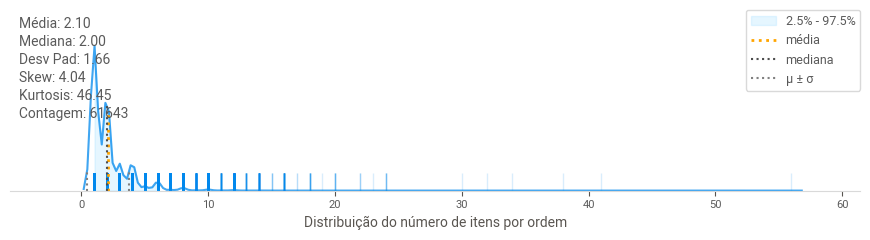

In [14]:
df_for_plot = df_agg_by_order["distinct_itens"]

plot_distribution(
    data=df_for_plot, 
    xlabel="Distribuição do número de itens por ordem",
);

## User Centric

In [15]:
df_agg_by_user = (
    df_agg_by_order
    .groupby(
        by="client_hash",
        observed=True,
    )
    .agg(
        recency=pd.NamedAgg(column="creation_date", aggfunc=lambda x: (pd.Timestamp.now(tz="America/Sao_Paulo") - x.max()).days),
        frequency=pd.NamedAgg(column="order", aggfunc="count"),
        monetary=pd.NamedAgg(column="total_value", aggfunc="sum")
    )
    .reset_index()
)
display(df_agg_by_user)

,client_hash,recency,frequency,monetary
0,0002a829ad89238ec96d22d7666c09f86fc8e209d55f2c...,196,1,148.190002
1,00040249691338dfd0ed04477561b3553d23eb6f446344...,279,1,119.970001
2,0004083d471868acd94861e331312ebdf505578ec600b6...,474,1,167.949997
3,00043d712019889689b32f039ddcfe749ba14fa5b1ad2c...,527,1,173.550003
4,0006494d8bb2603742881a0d9e50aee30619d3221c3532...,157,1,191.910004
...,...,...,...,...
45885,fff554777df092cfa6309a3ddba1447413e1f0deb50b6c...,463,1,255.679993
45886,fff8e0d837f1204bd90aba64facef55b5516a8d33f3e8d...,25,1,189.220001
45887,fffaa5762ce4b80d73a54f1b5a4df0b88c3c41dda4bf38...,573,1,197.039993
45888,fffc161aab8993d2eb4f05e113c31628acecacb720fcc1...,498,1,303.910004


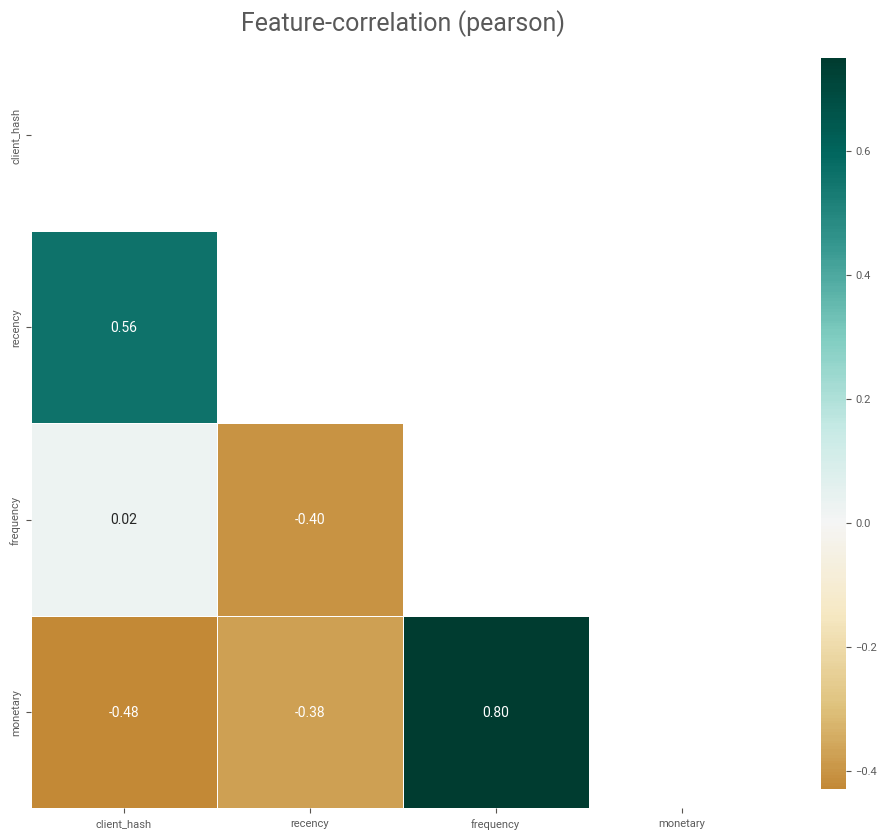

In [16]:
describe.corr_plot(
    data=nominal.associations(
        dataset=df_agg_by_user,
        numerical_columns=[
            "recency",
            "frequency",
            "monetary"
        ],
        nom_nom_assoc="cramer",
        num_num_assoc="spearman",
        nom_num_assoc="correlation_ratio",
        nan_strategy="replace",
        nan_replace_value="null",
        cramers_v_bias_correction=False,
        compute_only=True
    )["corr"]
);

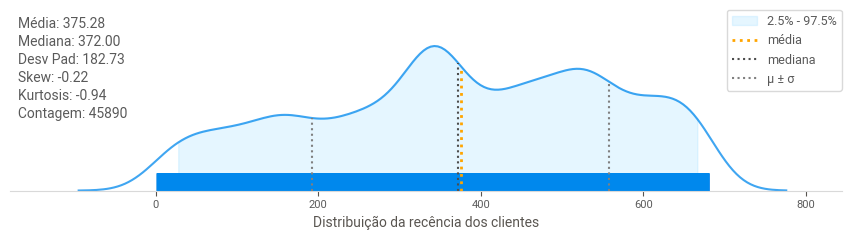

In [17]:
df_for_plot = df_agg_by_user["recency"]

plot_distribution(
    data=df_for_plot, 
    xlabel="Distribuição da recência dos clientes",
);

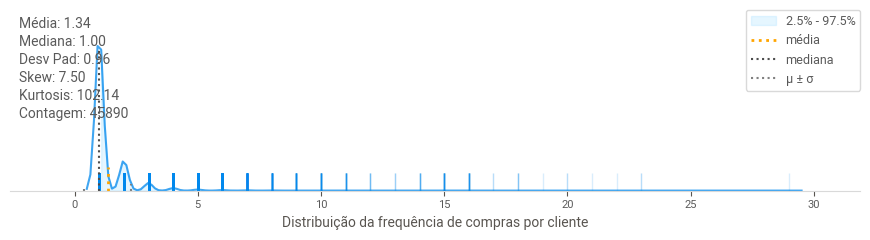

In [18]:
df_for_plot = df_agg_by_user["frequency"]

plot_distribution(
    data=df_for_plot, 
    xlabel="Distribuição da frequência de compras por cliente",
);

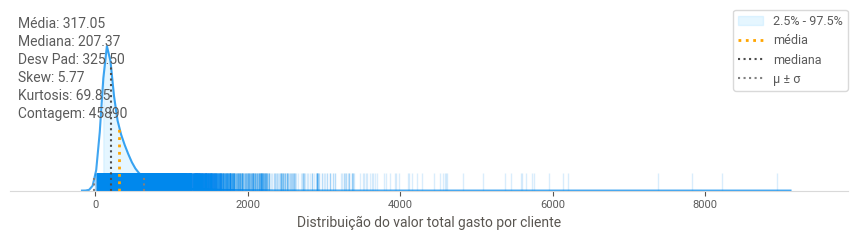

In [19]:
df_for_plot = df_agg_by_user["monetary"]

plot_distribution(
    data=df_for_plot, 
    xlabel="Distribuição do valor total gasto por cliente",
);

# Insights

*English*

## Order Centric
- Client Origin Correlation: The origin of the client is correlated with the total order value (from sweetviz report).
- City and Coupon Usage: Certain cities are correlated with the use of coupons.
- Order Trend: The number of orders has been decreasing over time.
- Sales Trend: The total sales value has also decreased over the period.
- Average Ticket Value: The average ticket value has increased, indicating a change in the purchase profile.
- Order Composition: It is quite common for orders to have more than one item (average is two), presenting potential for exploring recommendation systems in the business.

## User Centric
- Recency Distribution: The recency of purchases is well distributed, centered around 372 days (around an year). But there is a concentration also around 600 days, which means that there is a high number of customers that did not purchase more than one time.
- Purchase Frequency: The overall purchase frequency of customers is low (median = 1 and mean = 1). This corroborates with the insights from the recency distribution.
- Spending Distribution: The distribution of spending per customer is more varied and shows a high standard deviation compared to the mean (standard deviation = 325 and mean = 317). The format of the distribution and the median being 217 indicates to a scenario in which many customers spends little and a few customers have a high spending.
- Customer Base: There are 45.890 distinct customers for 61.643 orders in the period, corroborating the low purchase frequency.

## Overall
- Observation Period: the business is highly impacted by the seasonality of the year, but there are signs of a profile shift over time: there are less sales with a higher average ticket.
- Recency Dimension: The recency dimension is the most negatively impacted for good segmentation delimitation, as it is more concentrated around 1.
- Distribution Shape: Almost all distributions are close to a normal shape with a long tail and positive skewness.
- Outlier Approach: With a relatively small customer base, it is worth approaching outliers more directly (such as customers who made more than 5 purchases and/or spent R$ 1,000.00). The correlation of the customer with the total value also points to this.

*Português-BR*

## Centrado no Pedido
- Correlação da Origem do Cliente: A origem do cliente está correlacionada com o valor total do pedido (do relatório sweetviz).
- Cidade e Uso de Cupons: Certas cidades estão correlacionadas com o uso de cupons.
- Tendência de Pedidos: O número de pedidos tem diminuído ao longo do tempo.
- Tendência de Vendas: O valor total das vendas também diminuiu ao longo do período.
- Valor Médio do Ticket: O valor médio do ticket aumentou, indicando uma mudança no perfil de compra.
- Composição do Pedido: É bastante comum que os pedidos tenham mais de um item (a média é de dois), apresentando potencial para explorar sistemas de recomendação no negócio.

## Centrado no Usuário
- Distribuição da Recência: A recência das compras está bem distribuída, centrada em torno de 372 dias (cerca de um ano). Mas há uma concentração também em torno de 600 dias, o que significa que há um grande número de clientes que não compraram mais de uma vez.
- Frequência de Compras: A frequência geral de compras dos clientes é baixa (mediana = 1 e média = 1). Isso corrobora com os insights da distribuição de recência.
- Distribuição de Gastos: A distribuição de gastos por cliente é mais variada e mostra um alto desvio padrão em comparação com a média (desvio padrão = 325 e média = 317). O formato da distribuição e a mediana sendo 217 indicam um cenário em que muitos clientes gastam pouco e alguns clientes têm um gasto alto.
- Base de Clientes: Existem 45.890 clientes distintos para 61.643 pedidos no período, corroborando a baixa frequência de compras.

## Geral
- Período de Observação: o negócio é altamente impactado pela sazonalidade do ano, mas há sinais de uma mudança de perfil ao longo do tempo: há menos vendas com um ticket médio mais alto.
- Dimensão da Recência: A dimensão da recência é a mais negativamente impactada para uma boa delimitação de segmentação, pois está mais concentrada em torno de 1.
- Forma da Distribuição: Quase todas as distribuições estão próximas de uma forma normal com uma cauda longa e assimetria positiva.
- Abordagem de Outliers: Com uma base de clientes relativamente pequena, vale a pena abordar outliers mais diretamente (como clientes que fizeram mais de 5 compras e/ou gastaram R$ 1.000,00). A correlação do cliente com o valor total também aponta para isso.